# Подготовка

### Импортируем необходимые библиотеки

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

import requests
from urllib.parse import urlencode

from scipy.stats import norm, shapiro, mannwhitneyu
from tqdm.auto import tqdm

!pip install pandahouse
import pandahouse as ph

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for pandahouse: filename=pandahouse-0.2.7-py2.py3-none-any.whl size=5921 sha256=b043d2098c5dcf6cfe42c14b2fcdf72f5c664ce3853ea3778d647445df1c4fa4
  Stored in directory: /root/.cache/pip/wheels/a5/21/86/0baf87a3ad07ced200fa982d25162c82bb099114382cdeaa46
Successfully built pandahouse


### Зададим настройки графиков

In [3]:
sns.set(rc={'figure.figsize': (10, 5),
            'axes.titlesize': 18,
            'axes.labelsize': 14},
        style="whitegrid")

### Создадим функцию для дополнения датафрейма новыми данными

In [4]:
def add_groups(df_stud, add_file):
    """Функция, дополняющая датафрейм новыми данными"""
    # На вход подается датафрейм с первоначалаьной информацией - df_stub, и дополнительной - add_file
    # прочитаем данные и сделаем колонку с id студентов индексами
    add_data = add_file
    add_data.set_index(keys='id', inplace=True, drop=True)
    
    # добавим новую группу к студентам
    df_stud = df_stud.fillna(add_data)
        
    return df_stud

### Применим функцию для проверки гипотез с помощью бустрапа

In [5]:
def get_bootstrap(
    data_column_1,                  # числовые значения первой (контрольной) выборки
    data_column_2,                  # числовые значения второй (тестовой) выборки
    boot_it=1000,                   # количество бутстрэп-подвыборок
    statistic=np.mean,              # интересующая нас статистика
    bootstrap_conf_level=0.95       # уровень значимости
):
    
    boot_len = max([len(data_column_1), len(data_column_2)])
    boot_data = []
    
    for i in tqdm(range(boot_it)):  # извлекаем подвыборки
        samples_1 = data_column_1.sample(
            boot_len, 
            replace=True  # параметр возвращения
        ).values
        
        samples_2 = data_column_2.sample(
            boot_len, 
            replace=True
        ).values
        
        samples_delta = samples_2 - samples_1        # находим разницу подвыборок
        boot_data.append(statistic(samples_delta))   # применяем статистику для разниц подвыборок
        
    pd_boot_data = pd.DataFrame(boot_data)

    # доверительный интервал 
    left_quant = (1 - bootstrap_conf_level) / 2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    ci = pd_boot_data.quantile([left_quant, right_quant])
        
    p_1 = norm.cdf(
        x=0, 
        loc=np.mean(boot_data), 
        scale=np.std(boot_data)
    )
    p_2 = norm.cdf(
        x=0, 
        loc=-np.mean(boot_data), 
        scale=np.std(boot_data)
    )
    p_value = min(p_1, p_2) * 2
        
    # отисовка графиков

    plt.hist(pd_boot_data[0], bins=50)
    plt.style.use('ggplot')
    plt.vlines(ci, ymin=0, ymax=50, linestyle='--')
    plt.xlabel('boot_data')
    plt.ylabel('frequency')
    plt.title("Histogram of boot_data")
    plt.show()
       
    return {"ci": ci, 
            "p_value": p_value}

# Проработаем алгоритм загрузки данных и их предварительного анализа

In [6]:
def get_data(df_url, sep=';'):
    """Функция для загрузки данных и их преобразования в датафрейм"""
    
    base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?'
    
    # Получаем загрузочную ссылку
    final_url = base_url + urlencode(dict(public_key=df_url))
    response = requests.get(final_url)
    download_url = response.json()['href']

    # Загружаем файл и сохраняем его
    df = pd.read_csv(download_url, sep=sep)
    
    return df

In [7]:
groups_url = 'https://disk.yandex.ru/d/58Us0DWOzuWAjg'
group_add_url = 'https://disk.yandex.ru/d/3aARY-P9pfaksg'
active_studs_url = 'https://disk.yandex.ru/d/prbgU-rZpiXVYg'
checks_url = 'https://disk.yandex.ru/d/84hTmELphW2sqQ'

In [8]:
groups = get_data(groups_url)
groups_add = get_data(group_add_url, sep=',')
active_studs = get_data(active_studs_url)
checks = get_data(checks_url)

In [9]:
groups.head(2)

,id,grp
0,1489,B
1,1627,A


In [10]:
groups_add.head(2)

,id,grp
0,5694584,B
1,5694830,B


In [11]:
active_studs.head(2)

,student_id
0,581585
1,5723133


In [12]:
checks.head(2)

,student_id,rev
0,1627,990.0
1,3185,690.0


In [13]:
lst = ['shape', 'miss_data', 'data_types', 'cnt_unique_elements']                                                    

In [14]:
def explan(df, lst=lst):
    """Функция определяет размеры датасета, наличие пропусков и типы данных, считает количество уникальных элементов"""
    data = {'shape': df.shape, 
            'miss_data': df.isna().sum(), 
            'data_types': df.dtypes, 
            'cnt_unique_elements': df.nunique()}
    
    for i in lst:
        print(f"{str.capitalize(i)}\n{ data[i]} \n")

In [15]:
explan(groups)

Shape
(74484, 2) 

Miss_data
id     0
grp    0
dtype: int64 

Data_types
id      int64
grp    object
dtype: object 

Cnt_unique_elements
id     74484
grp        2
dtype: int64 



In [16]:
explan(groups_add)

Shape
(92, 2) 

Miss_data
id     0
grp    0
dtype: int64 

Data_types
id      int64
grp    object
dtype: object 

Cnt_unique_elements
id     92
grp     2
dtype: int64 



In [17]:
explan(active_studs)

Shape
(8341, 1) 

Miss_data
student_id    0
dtype: int64 

Data_types
student_id    int64
dtype: object 

Cnt_unique_elements
student_id    8341
dtype: int64 



In [18]:
explan(checks)

Shape
(541, 2) 

Miss_data
student_id    0
rev           0
dtype: int64 

Data_types
student_id      int64
rev           float64
dtype: object 

Cnt_unique_elements
student_id    541
rev            39
dtype: int64 



__Пропуски не обнаружены, данные в соотвествующих колонках датасетов имеют одинаковый тип. Продолжаем исследовать данные__

In [19]:
active_studs.rename(columns={'student_id': 'id'}, inplace=True)  # зададим одинаковые заголовки для колонок
checks.rename(columns={'student_id': 'id'}, inplace=True) 

Посмотрим, есть ли у нас платящие пользователи, которые не являются активными

In [20]:
active_studs['activity_status'] = 1  # отмечаем "активных" пользователей цифрой 1
df = checks.merge(active_studs, how='left', on='id').query('activity_status != 1').fillna(0)  # а "неактивных" 0

In [21]:
df.shape

(149, 3)

__Как мы видим, есть 149 пользователей произвели оплату, но при этом были неактивны в период проведения эксперимента. Такая ситуация могла возникнуть по целому ряду причин, но, скорее всего, имеет место быть либо техническая ошибка, либо данные пользователи имеют активную подписку. У нас нет точных данных, что именно произошло, а потому предположим, что произошел технический сбой и будем считать всех пользователей, совершивших оплату активными. Объединим все датафреймы.__

In [22]:
all_users = add_groups(groups, groups_add)  # используем функцию добавления новых данных

Проверим получвшийся датасет с помощью функции explan

In [23]:
explan(all_users)

Shape
(74484, 2) 

Miss_data
id     0
grp    0
dtype: int64 

Data_types
id      int64
grp    object
dtype: object 

Cnt_unique_elements
id     74484
grp        2
dtype: int64 



Примерджим остальные датасеты

In [24]:
full_data = pd.merge(all_users, active_studs, how='left', on='id')
full_data = pd.merge(full_data, checks, how='left', on='id')
full_data = full_data.fillna(0)

In [25]:
full_data

,id,grp,activity_status,rev
0,1489,B,0.0,0.0
1,1627,A,1.0,990.0
2,1768,B,0.0,0.0
3,1783,B,0.0,0.0
4,1794,A,0.0,0.0
...,...,...,...,...
74479,5692459,B,0.0,0.0
74480,5692572,B,0.0,0.0
74481,5692865,B,0.0,0.0
74482,5693667,B,0.0,0.0


In [26]:
explan(full_data)  # еще раз проверяем

Shape
(74484, 4) 

Miss_data
id                 0
grp                0
activity_status    0
rev                0
dtype: int64 

Data_types
id                   int64
grp                 object
activity_status    float64
rev                float64
dtype: object 

Cnt_unique_elements
id                 74484
grp                    2
activity_status        2
rev                   40
dtype: int64 



Для дальнейшего анализа отберем только активных пользователей.

In [27]:
active_users = full_data.query('activity_status != 0 or rev > 0')

In [28]:
active_users

,id,grp,activity_status,rev
1,1627,A,1.0,990.0
10,2085,B,1.0,0.0
12,2215,B,1.0,0.0
39,3185,B,0.0,690.0
43,3391,A,1.0,0.0
...,...,...,...,...
74452,5681918,B,1.0,1900.0
74456,5685258,B,1.0,0.0
74461,5688310,B,1.0,0.0
74464,5689627,B,1.0,0.0


# Определимся с метриками

Чтобы понять какой эффект произвело изменение механизма оплаты на поведения пользователей сравним выручку в контрольной и тестовой группе

Для оценки выручки будем использовать показатель среднего дохода на платящего пользователя - ___ARPPU___. Он находится в прямой зависимости от конверсии из зарегистрированного пользователя в платящего - ___CR___ и средней выручки на пользователя - ___ARPU___. 

Таким образом, мы можем посчитать ARPPU как:
___ARPU / (NumberOfUsers * CR)___

Для начала подготовим наши данные

In [29]:
revenue = active_users.groupby('grp', as_index=False) \
                      .agg({'rev': 'sum'}).round(2).rename(columns={'rev': 'revenue'})

revenue  # нашли распредение выручки

,grp,revenue
0,A,92096.0
1,B,479330.0


In [30]:
groups_user = active_users.groupby('grp', as_index=False) \
                          .agg({'id': 'count'}).rename(columns={'id': 'users'})

groups_user  # активные пользователи в группах

,grp,users
0,A,1564
1,B,6913


In [31]:
groups_buyers = active_users.query('rev > 0').groupby('grp', as_index=False) \
                            .agg({'id': 'count'}).rename(columns={'id': 'buyers'})

groups_buyers  # платящие пользователи в группах

,grp,buyers
0,A,107
1,B,433


Для дальнейших расчетов объеденим получившиеся датафреймы

In [32]:
df1 = groups_user.merge(groups_buyers).merge(revenue)
df1

,grp,users,buyers,revenue
0,A,1564,107,92096.0
1,B,6913,433,479330.0


In [33]:
df1['avg_check'] = (df1.revenue / df1.buyers).round(2)
df1['ARPU'] = (df1.revenue / df1.users).round(2)
df1['ARPPU'] = (df1.revenue / df1.buyers).round(2)
df1['CR'] = (df1.buyers / df1.users)
df1

,grp,users,buyers,revenue,avg_check,ARPU,ARPPU,CR
0,A,1564,107,92096.0,860.71,58.88,860.71,0.068414
1,B,6913,433,479330.0,1107.00,69.34,1107.00,0.062636


В итоге мы получаем что в тестовой группе выросли показатели средний чек, ARPU и ARPPU,но при этом произошло снижение конверсии в покупку(CR). Так же стоит отметить что показатели средний чек и ARPPU равны, это говорит о том, что за анализируемый период пользователи совершили только по одной покупке. Распределим данные на контрольную и тестовую группу.

In [34]:
control = active_users.query('grp == "A" and rev > 0')
test = active_users.query('grp == "B" and rev > 0')

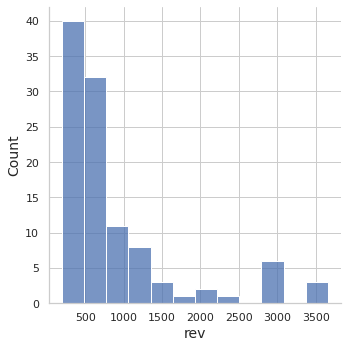

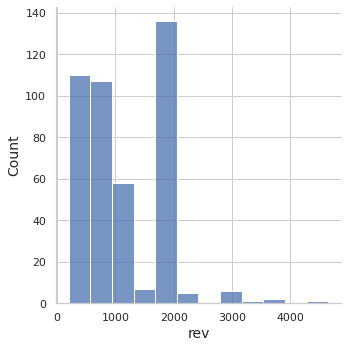

In [35]:
sns.displot(control.rev)
sns.displot(test.rev)

Графики говорят нам о том, что разпределение выручки не является нормальным. Убедимся в этом с помощью теста Шапиро.

In [36]:
shapiro(test.rev)

ShapiroResult(statistic=0.867313027381897, pvalue=9.542798088039443e-19)

In [37]:
shapiro(control.rev)

ShapiroResult(statistic=0.7196124196052551, pvalue=5.321687643507211e-13)

Критерий Шапиро-Уилка подтвердил, что оба распределения нельзя считать нормальными. С помощью боксплота проверим нет ли у нас значительных выбросов по контрольной и тестовой группах

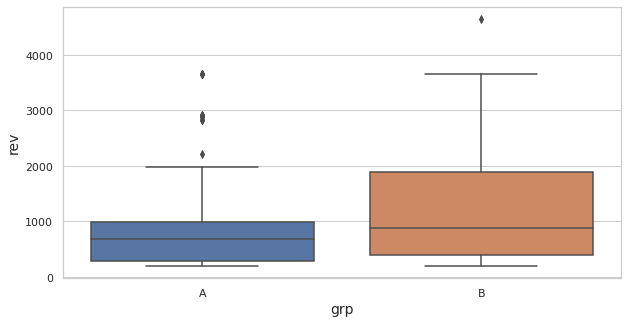

In [38]:
sns.boxplot(data=active_users.query('rev > 0'), x='grp', y='rev')

#### Сравним метрику ARPPU в разных группах

Здесь можно увидеть, что присутствуют незначительные выбросы. 
Для дальнейшего анализа выберем метод Bootstrap. 
Примем 2 гипотезы:     
    * Н0 - нет различия между контрольной и тестовой группами,
    * Н1 - средние значения различаются между группами

  0%|          | 0/10000 [00:00<?, ?it/s]

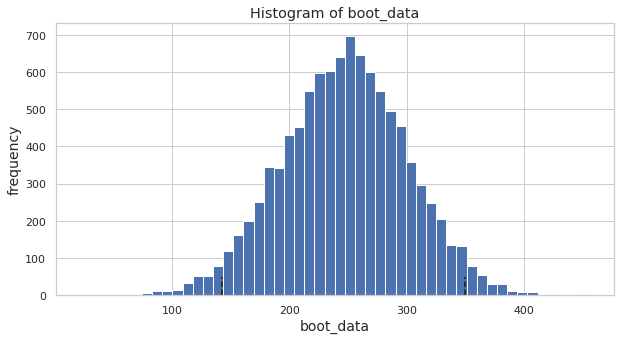

In [39]:
booted_data = get_bootstrap(control.rev,
                            test.rev,
                            boot_it=10000, 
                            statistic=np.mean,
                            bootstrap_conf_level=0.95)

In [40]:
booted_data["p_value"]

3.429967469216674e-06

In [41]:
booted_data["ci"]

,0
0.025,142.379166
0.975,349.836555


___Так p-value < 0,05 и доверительный интервал не включает 0, мы имеем все основания для того, чтобы отвергнуть нулевую гипотезу об отсутствие различий между медианнами в двух группах___

In [42]:
mannwhitneyu(control.rev, test.rev)

MannwhitneyuResult(statistic=17850.0, pvalue=0.00021019690333618245)

__Тест Манна-Уитни также сигнализирует о том, что следует распространить изменения в механизме оплаты на всех пользователей__

#####__SQL__

Образовательные курсы состоят из различных уроков, каждый из которых состоит из нескольких маленьких заданий. Каждое такое маленькое задание называется "горошиной".

Назовём очень усердным учеником того пользователя, который хотя бы раз за текущий месяц правильно решил 20 горошин за час.

Необходимо написать оптимальный запрос, который даст информацию о количестве очень усердных студентов за март 2020 года.

NB! Под усердным студентом мы понимаем студента, который правильно решил 20 задач за текущий месяц.

Подключимся к базе данных с помощью библиотеки pandahouse, и создадим c словарь необходимыми параметрами

In [1]:
connection_default = {'host': 'https://clickhouse.lab.karpov.courses',
                      'database': 'default',
                      'user': 'student', 
                      'password': 'dpo_python_2020'}

Напишем сам запрос

In [43]:
q = '''SELECT
        COUNT(DISTINCT st_id) AS diligent_stud_cnt
    FROM
        (SELECT 
            st_id,
            subject,
            SUM(correct) AS good_task_counter 
        FROM peas
        WHERE 
            (toMonth(timest) = 3) 
            AND
            (toYear(timest) = 2020)
        GROUP BY 
            st_id, subject
        HAVING
            good_task_counter >= 20)
    '''

Отправим запрос и запишем результат в датафрейм

In [44]:
count_st = ph.read_clickhouse(query=q, connection=connection_default)
count_st

,diligent_stud_cnt
0,0


Задание 2

Образовательная платформа предлагает пройти студентам курсы по модели trial: студент может решить бесплатно лишь 30 горошин в день. Для неограниченного количества заданий в определенной дисциплине студенту необходимо приобрести полный доступ. Команда провела эксперимент, где был протестирован новый экран оплаты.

Необходимо в одном запросе выгрузить следующую информацию о группах пользователей:

ARPU, 
ARPAU, 
CR в покупку, 
СR активного пользователя в покупку, 
CR пользователя из активности по математике (subject = ’math’) в покупку курса по математике.

In [45]:
'''Посчитаем метрики последующим формулам:
	1. ARPU = выручка / количество уникальных студентов, сделавших задачи
	
	2. ARPAU = выручка / общее количество активных студентов
	Активными студентами будем считать тех, кто выполнил задачи в течении месяца. Для начала подсчитаем ARPAU за месяц, а затем за весь период
	
	3. CR to purchase = количество уникальных студентов купивших курс / количство студентов,выполнивших задание
	
	4. CR from an active student to customer = количество уникальных студентов купивших курс / количество уникальных активных учеников

	5. CR from an active on math student to customer of math course = количество уникальных студентов купивших курс по математике / total оличество уникальных активны студентов, обучающихся математике.
	
    Для каждой метрики активными студентами будем считать тех, кто выполнил задачи в течении месяца. Посчитаем метрики отдельно за месяц и за весь период'''

'Посчитаем метрики последующим формулам:\n\t1. ARPU = выручка / количество уникальных студентов, сделавших задачи\n\t\n\t2. ARPAU = выручка / общее количество активных студентов\n\tАктивными студентами будем считать тех, кто выполнил задачи в течении месяца. Для начала подсчитаем ARPAU за месяц, а затем за весь период\n\t\n\t3. CR to purchase = количество уникальных студентов купивших курс / количство студентов,выполнивших задание\n\t\n\t4. CR from an active student to customer = количество уникальных студентов купивших курс / количество уникальных активных учеников\n\n\t5. CR from an active on math student to customer of math course = количество уникальных студентов купивших курс по математике / total оличество уникальных активны студентов, обучающихся математике.\n\t\n    Для каждой метрики активными студентами будем считать тех, кто выполнил задачи в течении месяца. Посчитаем метрики отдельно за месяц и за весь период'

In [46]:
q2 = '''
        SELECT 
            ar.test_grp as test_grp,
            ar.ARPU as ARPU,
            arp.ARPAU as ARPAU,
            crp.CR_in_purchase as CR_in_purchase,
            cra.CR_active as CR_active, 
            crm.CR_math as CR_math
        FROM
        (
            SELECT test_grp,
                round(sum(money)/count(DISTINCT(st_id)),2) as ARPU
            FROM 
                (
                SELECT 
                    final_project_check.st_id, 
                    toStartOfMonth(sale_time) as sale_time, 
                    money,
                    subject,
                    studs.test_grp
                FROM final_project_check
                right semi JOIN studs
                ON final_project_check.st_id = studs.st_id
                WHERE sale_time >= '2020-07-01')
            GROUP BY test_grp
        ) AS ar

        JOIN

            (
            SELECT test_grp, round(sum(money)/COUNT(DISTINCT(st_id)),2) AS ARPAU
            FROM 
                    (
                    SELECT 
                        final_project_check.st_id, 
                        toStartOfMonth(sale_time) AS sale_time, 
                        money, subject, 
                        studs.test_grp
                    FROM final_project_check
                    right semi JOIN studs
                    ON final_project_check.st_id = studs.st_id
                    WHERE sale_time >= '2020-07-01'
                    ) AS l
                    right semi JOIN 
                    (SELECT 
                        st_id, 
                        toStartOfMonth(timest) AS timest, 
                        subject
                    FROM peas
                    WHERE timest >= '2020-07-01'
                    ) AS b
                    ON l.st_id = b.st_id
            GROUP BY test_grp
            ) AS arp
        ON ar.test_grp = arp.test_grp


        JOIN

        (
            SELECT test_grp, COUNT(DISTINCT(b.st_id)) *100 / COUNT(DISTINCT(st_id))  AS CR_in_purchase
            FROM 
                (
                SELECT 
                    final_project_check.st_id,
                    toStartOfMonth(sale_time) as sale_time, 
                    money, subject, 
                    studs.test_grp
                FROM final_project_check
                right semi JOIN studs
                ON final_project_check.st_id = studs.st_id
                WHERE sale_time >= '2020-07-01'
                ) AS l
                right semi JOIN 
                (
                    SELECT 
                        st_id,
                        toStartOfMonth(timest) as timest, 
                        subject
                    FROM peas
                    WHERE timest >= '2020-07-01'
                ) AS b
                ON l.st_id = b.st_id

            GROUP BY test_grp
        ) AS crp

        ON ar.test_grp = crp.test_grp

        JOIN

        (
        SELECT 
            test_grp, 
            COUNT(DISTINCT(b.st_id)) *100 / COUNT(DISTINCT(st_id))  AS CR_active
        FROM 
            (
            SELECT 
                final_project_check.st_id, 
                toStartOfMonth(sale_time) as sale_time,
                money, 
                subject, 
                studs.test_grp
            FROM final_project_check
            right semi JOIN studs
            ON final_project_check.st_id = studs.st_id
            WHERE sale_time >= '2020-07-01'
            ) AS l
            right semi JOIN 
            (
            SELECT 
                st_id,
                toStartOfMonth(timest) AS timest, 
                subject
            FROM peas
            WHERE timest >= '2020-07-01'
            ) AS b
            ON l.st_id = b.st_id
        GROUP BY test_grp
        ) AS cra
        ON ar.test_grp = cra.test_grp

        JOIN
        (
            SELECT 
                test_grp, 
                round(CAST(st_id_buyer AS FLOAT) * 100 / CAST(st_id_active AS FLOAT), 2) AS CR_math
            FROM
            (
                SELECT 
                    test_grp, 
                    COUNT(distinct(st_id)) AS st_id_active
                FROM
                (
                SELECT 
                    st_id, 
                    toStartOfMonth(timest) as timest, 
                    subject
                FROM peas
                WHERE timest >= '2020-07-01' AND subject = 'Math') AS n
                right semi JOIN studs
                ON n.st_id = studs.st_id
                GROUP BY test_grp 
            ) AS k
            JOIN 
            (
            SELECT 
                test_grp, 
                COUNT(distinct(st_id)) AS st_id_buyer
            FROM 
                (
                SELECT 
                    final_project_check.st_id,
                    toStartOfMonth(sale_time) AS sale_time,
                    money, 
                    subject
                FROM final_project_check
                WHERE sale_time >= '2020-07-01' AND subject = 'Math') AS t
                right semi JOIN studs
                ON t.st_id = studs.st_id
                
            GROUP BY test_grp
            ) AS u
            ON k.test_grp = u.test_grp
        ) AS crm

        ON ar.test_grp = crm.test_grp
        '''

In [47]:
metrics = ph.read_clickhouse(query=q2, connection=connection_default)
metrics

,test_grp,ARPU,ARPAU,CR_in_purchase,CR_active,CR_math
0,control,77666.67,3488333.33,100.0,100.0,15.09
1,pilot,79375.00,3731666.67,100.0,100.0,35.56
